# Importation des modules

In [1]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np

from skimage import data

from PIL.Image import *

from imageio import imread
import glob
from tqdm import tnrange
from tqdm.notebook import tqdm_notebook
import tqdm
import torch
from torchvision import datasets,transforms
import torch.nn.functional as F
import torch.nn as nn
import torch.utils.model_zoo as model_zoo
from torchvision.utils import save_image

import multiprocessing



In [2]:
torch.cuda.is_available()

True

# Test de modèle


## Chargement du dataset

In [3]:
size = 120
deep = 3

In [4]:
def image_to_numpy(image) :
    n = len(image)
    image_bis = []
    for i in range (n) :
        image_bis.append([])
        for j in range(n) :
            image_bis[i].append(image[i][j][0])
    return np.array(image_bis)

In [5]:
list_images = []
list_labels = []

list_path = set()

path_imgs = "trans200/"

def select_unique_imgs():
    for image_path in tqdm_notebook(glob.glob(path_imgs + "*.png")):
        label = image_path.find('l')
        couche = image_path.find('c')
        id_image = image_path[:couche]
        label_image = int(image_path[label+1:couche])
        list_path.add((id_image, label_image))



def load_pictures(data_files):
    with multiprocessing.Pool() as p :
        res = list(tqdm.tqdm(p.imap(load_image3.load_img_from_path, data_files), total=len(data_files)))
    for lot_lab, lot_img in tqdm.tqdm(res, total=len(res)):
        list_images.append(lot_img)
        list_labels.append(lot_lab)

In [6]:
select_unique_imgs()

In [7]:
import load_image3


if __name__ ==  '__main__' : 
    load_pictures(list_path)

100%|█████████████████████████████████████████████████████████████████████████| 7181/7181 [00:00<00:00, 1794952.15it/s]


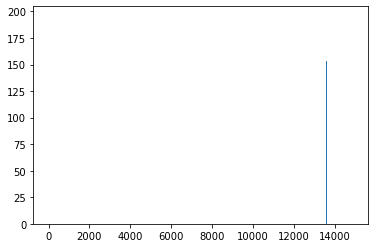

In [8]:
n = len(list_images)
num_label = plt.hist(list_labels, bins=range(max(list_labels)+2))

In [9]:
num_label = num_label[0]
deep=3

In [10]:
nouv_label = [-1]*(max(list_labels)+2)
compteur = 0
for i in range(max(list_labels)+1) :
    if num_label[i]>0 :
        nouv_label[i]=compteur
        compteur+=1

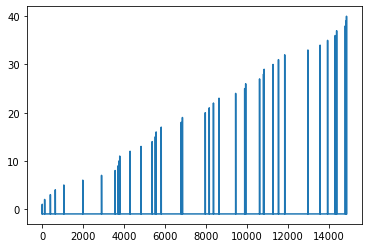

In [11]:
plt.plot(nouv_label)

In [12]:
label_max = max(nouv_label)
print(label_max)

40


In [13]:
nouv_list_labels = []
for i in range(len(list_labels)) :
    nouv_list_labels.append(nouv_label[list_labels[i]])

(array([173., 161., 190., 189., 174., 168., 163., 159., 192., 187., 161.,
        165., 181., 187., 157., 180., 165., 193., 187., 190., 136., 187.,
        160., 185., 195., 179., 160., 175., 193., 193., 153., 187., 190.,
        171., 153., 180., 184., 175., 164., 170., 169.]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41]),
 <BarContainer object of 41 artists>)

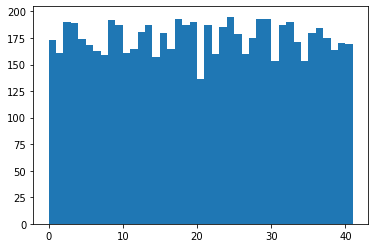

In [14]:
plt.hist(nouv_list_labels, bins=range(label_max +2))

In [15]:
num_classes = label_max+1
num_classes

41

In [16]:
def shuffle_in_unison(list_images, list_labels):
    assert len(list_images) == len(list_labels)
    shuffled_list_images = np.empty(list_images.shape, dtype=list_images.dtype)
    shuffled_list_labels = np.empty(list_labels.shape, dtype=list_labels.dtype)
    permutation = np.random.permutation(len(list_images))
    for old_index, new_index in enumerate(permutation):
        shuffled_list_images[new_index] = list_images[old_index]
        shuffled_list_labels[new_index] = list_labels[old_index]
    return shuffled_list_images, shuffled_list_labels

In [17]:
len(list_images[3])

3

In [18]:
def list_to_torch(list_images, list_labels) :
    n = len(list_images)
    
    torch_images=np.array([np.asarray(data) for data in list_images])
    torch_labels=np.array(list_labels)
    
    torch_images, torch_labels=shuffle_in_unison(torch_images, torch_labels)
    
    torch_images = torch.from_numpy(torch_images).cuda()
    torch_labels = torch.from_numpy(torch_labels).cuda()
    
    train_set = torch.utils.data.TensorDataset(torch_images[:int(0.8*n)],torch_labels[:int(0.8*n)])
    test_set = torch.utils.data.TensorDataset(torch_images[int(0.8*n):],torch_labels[int(0.8*n):])
    
    return train_set, test_set

In [19]:
train_set, test_set = list_to_torch(list_images, nouv_list_labels)

In [20]:
def train_epoch(net, train_set, opt, criterion, batch_size):
    net.train()
    trainloader = torch.utils.data.DataLoader(train_set, batch_size)
    for x_batch, y_batch in trainloader :
        opt.zero_grad()
        # Forward
        y_pred = net(x_batch.float())
        y_batch = y_batch.long()
        # Compute diff
        loss = criterion(y_pred, y_batch)
        # Compute gradients
        loss.backward()
        # update weights
        opt.step()

def accuracy(net, dataset):
    net.eval()
    correct = 0
    trainloader = torch.utils.data.DataLoader(dataset, batch_size=1)
    for x_batch, y_batch in trainloader :
        y_pred = net(x_batch.float())
        y_pred = torch.argmax(y_pred).int()
        if int(y_pred)==int(y_batch[0]) :
            correct+=1
    return correct/len(dataset)

## Classes entrainés

In [21]:
model_urls = {
    'vgg11': 'https://download.pytorch.org/models/vgg11-bbd30ac9.pth',
    'vgg11_bn': 'https://download.pytorch.org/models/vgg11_bn-6002323d.pth', # bn: batch normalization
    'vgg19_bn': 'https://download.pytorch.org/models/vgg19_bn-c79401a0.pth'
}


class VGG(nn.Module):

    def __init__(self, features, num_classes=1000, init_weights=True):
        super(VGG, self).__init__()
        self.features = features
        self.avgpool = nn.AdaptiveAvgPool2d((7, 7))
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, num_classes),
        )
        if init_weights:
            self._initialize_weights()

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)


def make_layers(cfg, batch_norm=False):
  layers = []
  prec_deep = 3
  for truc in cfg :
    if truc=='M' :
      layers.append(nn.MaxPool2d(2,None,0))
    else :
      layers.append(nn.Conv2d(prec_deep,truc,3,1,1))
      if batch_norm :
        layers.append(nn.BatchNorm2d(truc))
      layers.append(nn.ReLU(inplace=True))
      prec_deep = truc
  return nn.Sequential(*layers)



cfg = { # M stands for max pooling 
    'A': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'B': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'D': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'E': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}

In [22]:
def vgg_11_classifier(num_classes):
  classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(512 * 7 * 7, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(128, 64),
            nn.ReLU(inplace=True),
            nn.Linear(64, num_classes),
        )
  return classifier
  
def vgg11_bn(num_classes, pretrained=False, letter='E', **kwargs):
    """VGG 11-layer model (configuration "A") with batch normalization
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    if pretrained:
        kwargs['init_weights'] = False
    model = VGG(make_layers(cfg[letter], batch_norm=True), **kwargs) # change cfg version for bonus
    if pretrained:
      if letter == 'A' :
        model.load_state_dict(model_zoo.load_url(model_urls['vgg11_bn'])) # change model url for bn
      elif letter == 'E' :
        model.load_state_dict(model_zoo.load_url(model_urls['vgg19_bn']))
      else :
        print("Lettre non prise en charge")
    model.classifier = vgg_11_classifier(num_classes)
    return model

In [23]:
class Inception(nn.Module):
    def __init__(self, in_planes, kernel_1_x, kernel_3_in, kernel_3_x, kernel_5_in, kernel_5_x, pool_planes):
        super(Inception, self).__init__()

        #first scale :
        self.first_scale = nn.Conv2d(in_planes, kernel_1_x, kernel_size=1, padding=0)

        #second scale :
        second_scale_1 = nn.Conv2d(in_planes, kernel_3_in, kernel_size=1, padding=0)
        second_scale_2 = nn.Conv2d(kernel_3_in, kernel_3_x, kernel_size=3, padding=1)

        self.second_scale = nn.Sequential(second_scale_1,second_scale_2)

        #third scale :
        third_scale_1 = nn.Conv2d(in_planes, kernel_5_in, kernel_size=1, padding=0)
        third_scale_2 = nn.Conv2d(kernel_5_in, kernel_5_x, kernel_size=5, padding=2)

        self.third_scale = nn.Sequential(third_scale_1,third_scale_2)


        #forth scale :
        forth_scale_1 = nn.MaxPool2d(3,1, padding=1)
        forth_scale_2 = nn.Conv2d(in_planes, pool_planes, kernel_size=1, padding=0)   
        
        self.forth_scale = nn.Sequential(forth_scale_1,forth_scale_2)


    def forward(self, x):
      
      x1 = self.first_scale(x)
      x2 = self.second_scale(x)
      x3 = self.third_scale(x)
      x4 = self.forth_scale(x)
        
      res = torch.cat([x1,x2,x3,x4],1)
      return res


class GoogLeNet(nn.Module):
    def __init__(self, input_dim=9):
        super(GoogLeNet, self).__init__()
        self.pre_layers = nn.Sequential(
            nn.Conv2d(input_dim, 192, kernel_size=3, padding=1),
            nn.BatchNorm2d(192),
            nn.ReLU(True),
        )
        
        self.layer1 = Inception(192,  64,  96, 128, 16, 32, 32)
        
        self.layer2 = Inception(256, 128, 128, 192, 32, 96, 64)
        
        self.layer3 = Inception(480, 192,  96, 208, 16,  48,  64)
        
        #classifier
        self.max_pool = nn.MaxPool2d(3, stride=2, padding=1)
        
        self.avgpool = nn.AvgPool2d(8, stride=1)
        self.linear = nn.Linear(512, 655)
        

    def forward(self, x):
        
        x = self.pre_layers(x)
        x = self.layer1(x)
        x = self.max_pool(x)
        x = self.layer2(x)
        x = self.max_pool(x)
        x = self.layer3(x)
        x = self.max_pool(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.linear(x)
        return x


## Classes merge

In [24]:
class GoogLeNet_conv(nn.Module):
    def __init__(self, input_dim=9):
        super(GoogLeNet_conv, self).__init__()
        self.pre_layers = nn.Sequential(
            nn.Conv2d(input_dim, 192, kernel_size=3, padding=1),
            nn.BatchNorm2d(192),
            nn.ReLU(True),
        )
        
        self.layer1 = Inception(192,  64,  96, 128, 16, 32, 32)
        
        self.layer2 = Inception(256, 128, 128, 192, 32, 96, 64)
        
        self.layer3 = Inception(480, 192,  96, 208, 16,  48,  64)
        
        #classifier
        self.max_pool = nn.MaxPool2d(3, stride=2, padding=1)
        
        self.avgpool = nn.AvgPool2d(13, stride=1)
        

    def forward(self, x):
        
        x = self.pre_layers(x)
        x = self.layer1(x)
        x = self.max_pool(x)
        x = self.layer2(x)
        x = self.max_pool(x)
        x = self.layer3(x)
        x = self.max_pool(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        return x


In [25]:
class VGG_conv(nn.Module):

    def __init__(self, features, num_classes=1000, init_weights=True):
        super(VGG_conv, self).__init__()
        self.features = features
        self.avgpool = nn.AdaptiveAvgPool2d((7, 7))
        if init_weights:
            self._initialize_weights()
        self.max_pool = nn.MaxPool2d(3, stride=3, padding=1)

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = self.max_pool(x)
        x = x.view(x.size(0), -1)
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

In [26]:
def vgg11_bn_conv(num_classes, pretrained=False, letter='E', **kwargs):
    """VGG 11-layer model (configuration "A") with batch normalization
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    if pretrained:
        kwargs['init_weights'] = False
    model = VGG_conv(make_layers(cfg[letter], batch_norm=True), **kwargs) # change cfg version for bonus
    if pretrained:
      if letter == 'A' :
        model.load_state_dict(model_zoo.load_url(model_urls['vgg11_bn'])) # change model url for bn
      elif letter == 'E' :
        model.load_state_dict(model_zoo.load_url(model_urls['vgg19_bn']))
      else :
        print("Lettre non prise en charge")
    return model.cuda()

In [27]:
size_ggnet = 4608
size_vgg = 4608

In [28]:
class merge_net(nn.Module):
    def __init__(self, conv_vgg, conv_ggnet):
        super(merge_net, self).__init__()
        self.conv_vgg = conv_vgg
        self.conv_ggnet = conv_ggnet
        self.linear = nn.Linear(size_ggnet + size_vgg, num_classes)


    def forward(self, x):
        
        x_vgg = self.conv_vgg(x)
        x_ggnet = self.conv_ggnet(x)
        
        
        x_cat = torch.cat([x_vgg, x_ggnet],1)
        
        y = self.linear(x_cat)
        
        return y


# Merge

In [29]:
ggnet_trained = GoogLeNet(3).cuda()
ggnet_trained.load_state_dict(torch.load("poids_models/ggnet_sup150_60_rgb.ckpt"))

<All keys matched successfully>

In [30]:
conv_ggnet = GoogLeNet_conv(3).cuda()

In [31]:
params_trained = ggnet_trained.named_parameters()
params = conv_ggnet.named_parameters()

dict_params_trained = dict(params_trained)
dict_params = dict(params)


for name in dict_params :
    dict_params[name].data.copy_(dict_params_trained[name])
    dict_params[name].data.requires_grad = False

In [32]:
vgg_trained = vgg11_bn(num_classes=num_classes, pretrained=True).cuda()

In [33]:
conv_vgg = vgg11_bn_conv(num_classes)

In [34]:
params_trained = vgg_trained.named_parameters()
params = conv_vgg.named_parameters()

dict_params_trained = dict(params_trained)
dict_params = dict(params)


for name in dict_params :
        dict_params[name].data.copy_(dict_params_trained[name])
        dict_params[name].data.requires_grad = False

C:\Users\stani\anaconda3\envs\modal\lib\site-packages\ipykernel_launcher.py:13: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  del sys.path[0]


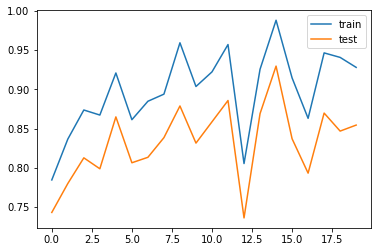

accuracy :


0.8545581071677105

In [35]:
epochs = 20
criterion = nn.CrossEntropyLoss()

net =  merge_net(conv_vgg,conv_ggnet).cuda()

opt = torch.optim.Adam(net.parameters(),lr=1e-3,betas=(0.9, 0.999),eps=1e-08)

compteur = 0

preci_train = []
preci_test = []

for i in tnrange(epochs) :
    train_epoch(net, train_set, opt, criterion, batch_size=10)
    preci_train.append(accuracy(net, train_set))
    preci_test.append(accuracy(net, test_set))

plt.plot(range(len(preci_train)), preci_train, label = "train")
plt.plot(range(len(preci_test)), preci_test, label =  "test")
plt.legend()
plt.show()

print("accuracy :") 
accuracy(net, test_set)